# 에스티메이터
## 4. 부스트된 트리 모델 이해
### 참고사이트 : https://www.tensorflow.org/tutorials/estimator/boosted_trees_model_understanding?hl=ko

In [35]:
import numpy as np
import pandas as pd
from IPython.display import clear_output

# Load dataset(타이타닉 data 활용)
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [36]:
import tensorflow as tf
tf.random.set_seed(123)

### < 부스트 트리 모델을 local 및 global하게 해석하는 방법 >

**local 해석**은 모델의 예측에 대한 이해를 의미   
**global 해석**은 모델 전체에 대한 이해를 의미   

이러한 기술은 ML(머신러닝) 실무자가 모델 개발 단계에서 Bias(편향)와 버그 감지에 도움

**local 해석**을 위해 instance 별 기여도를 작성하고 시각화   
(기능 중요도와 구분하기 위해 이러한 값을 방향성 기능 기여(DFC) 라고 함)   
**global 해석**을 위해 개인 기반 기능 중요도, 순열 기능 중요도를 검색해 시각화 하고 집계된 DFC도 표시

In [37]:
# data 전처리
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

In [38]:
# 입력 파이프라인 구축
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset.repeat(n_epochs).batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [39]:
# 모델 훈련(학습) 및 평가
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.803030
accuracy_baseline,0.625000
auc,0.864616
auc_precision_recall,0.854675
average_loss,0.418617
label/mean,0.375000
loss,0.418617
precision,0.758242
prediction/mean,0.382434
recall,0.696970


In [40]:
# 데이터가 메모리에 딱 맞으면 boosted_trees_classifier_train_in_memory 기능을 사용하는 것이 좋음.
# 하지만, 학습 시간이 중요하지 않거나 dataset이 매우 많다면, BoostedTreesClassifier API 사용
# 이 방법은 전체 dataset에서 작동하므로 입력 데이터를 일괄처리하면 안됨!
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# In-memory input_fn does not use batching.
def make_inmemory_train_input_fn(X, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

# Train the model.
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
print(est.evaluate(eval_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpkop57xlu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


In [41]:
# 모델 해석 및 플로팅
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

## Local 해석

In [42]:
# Local 해석
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpkop57xlu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

In [43]:
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.031089,0.092579,-0.177725,-0.081643,-0.063254,0.005449,0.483784
sex,264.0,0.004100,0.109387,-0.100808,-0.076052,-0.074326,0.138174,0.166265
class,264.0,0.016888,0.096127,-0.171331,-0.043370,-0.040795,0.031565,0.229792
deck,264.0,-0.016562,0.028900,-0.104268,-0.037882,-0.021543,0.001551,0.167450
fare,264.0,0.022909,0.090719,-0.208308,-0.034954,-0.012135,0.065481,0.245360
embark_town,264.0,-0.003467,0.031123,-0.051702,-0.010892,-0.009580,-0.003265,0.104475
n_siblings_spouses,264.0,0.002387,0.028452,-0.146794,0.002706,0.003291,0.006044,0.146853
parch,264.0,0.000743,0.006319,-0.068460,0.000242,0.000324,0.002251,0.024467
alone,264.0,0.000206,0.003676,-0.006822,0.000000,0.000000,0.000000,0.016494


In [44]:
# DFC의 좋은 특성은 contribute + bias가 label인 예측값과 같다는 것
# DFC + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

In [45]:
# 개별 승객에 대한 DFC를 플로팅하고 그림 추가
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

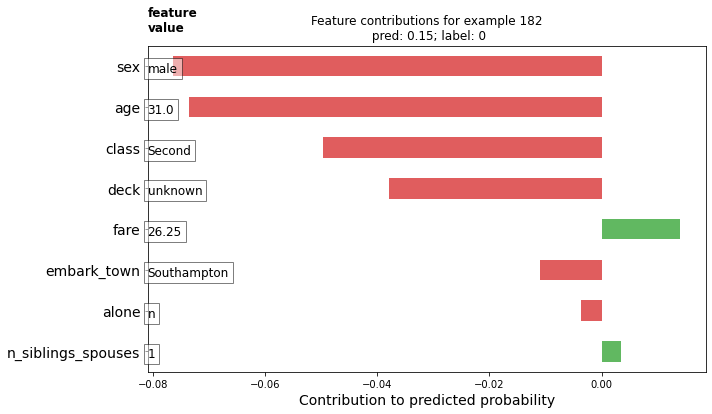

In [46]:
# 빨간색인 음의 값은 이 예제의 feature 값이 모델의 예측을 감소시켰다는 뜻
# 초록색인 양의 값은 이 예제의 feature 값이 모델의 예측을 증가시켰다는 뜻

# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

In [47]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')

  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')

  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)

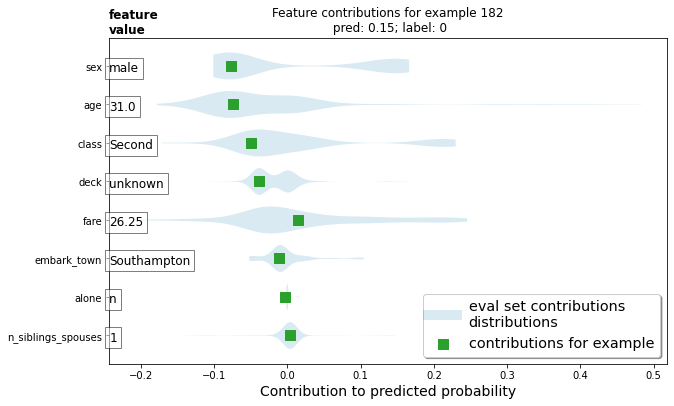

In [48]:
# 위의 함수를 활용해 예제의 DFC를 전체 분포와 비교 할 수 있음
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

## Global 해석

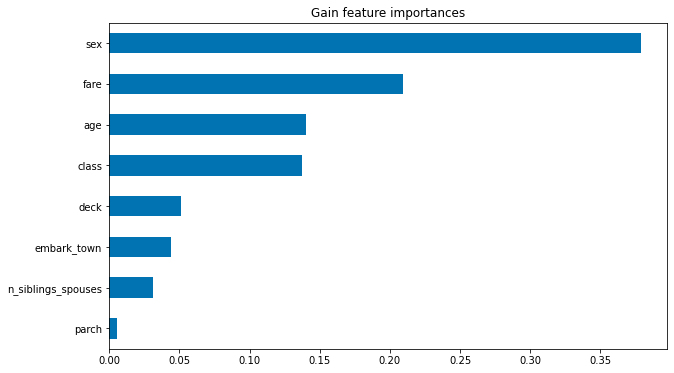

In [49]:
# 개별 예측을 연구하지 않고 모델 전체를 이해하기
# 1) 이득 기반 중요도 계산(est.experimental_feature_importances)
# 2) 순열의 중요성
# 3) est.experimental_predict_with_explanations를 사용하여 DFC 집계
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

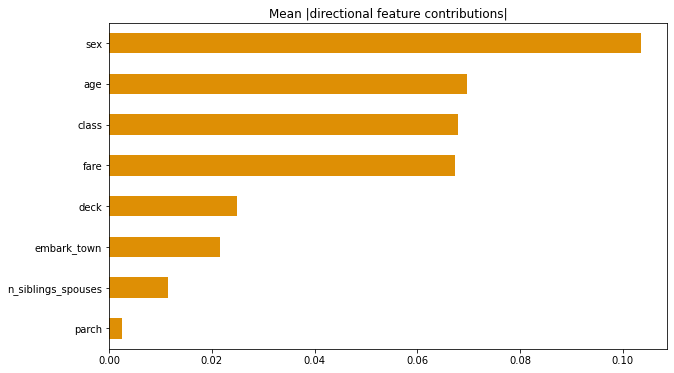

In [50]:
# DFC의 절대값 평균을 평균화하여 전체 모델의 수준 이해 할 수 있음.
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

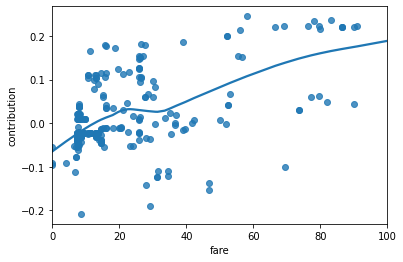

In [62]:
# 기능값이 다르면 DFC가 어떻게 변하는지도 확인 가능
FEATURE = 'fare' # 변경해가면서 확인 가능
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-23T10:24:14Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpkop57xlu/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.23675s
INFO:tensorflow:Finished evaluation at 2020-04-23-10:24:15
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.8030303, accuracy_baseline = 0.625, auc = 0.86069787, auc_precision_recall = 0.84781706, average_loss = 0.42241055, global_step = 153, label/mean = 0.375, loss = 0.42241055, precision = 0.75268817, prediction/mean = 0.38367626, recall = 0.7070707
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmpkop57xlu/model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-23T10:24:17Z
INFO:tensorflow:Graph was fi

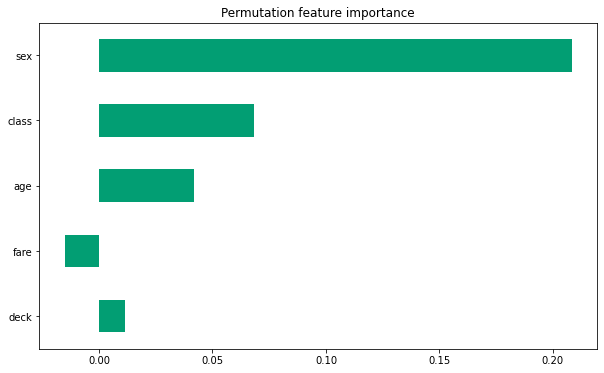

In [60]:
# 순열 기능의 중요성
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

In [63]:
# 모델 피팅 시각화
# 교육 데이터 시뮬레이션 생성(공식에 따라)
from numpy.random import uniform, seed
from scipy.interpolate import griddata

# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2) # 이게 공식!!

xy = np.zeros((2,np.size(x)))
xy[0] = x
xy[1] = y
xy = xy.T

In [64]:
# Prep data for training.
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [65]:
def plot_contour(x, y, z, **kwargs):
  # Grid the data.
  plt.figure(figsize=(10, 8))
  # Contour the gridded data, plotting dots at the nonuniform data points.
  CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
  CS = plt.contourf(x, y, z, 15,
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
  plt.colorbar()  # Draw colorbar.
  # Plot data points.
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

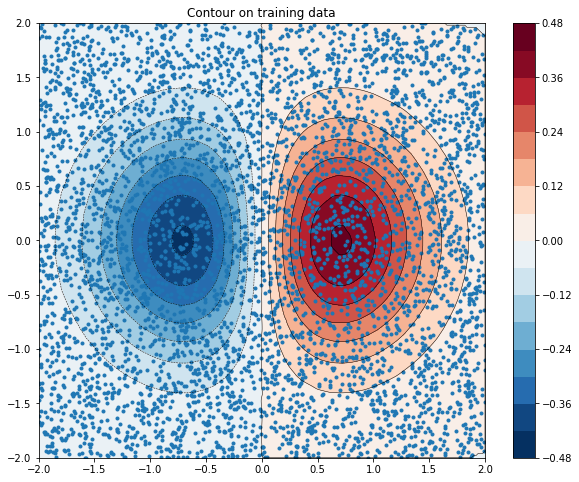

In [66]:
# 붉은 색이 더 큰 값(function value)
zi = griddata(xy, z, (xi, yi), method='linear', fill_value='0')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [67]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [68]:
def predict(est):
  """Predictions from a given estimator."""
  predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
  preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
  return preds.reshape(predict_shape)

In [69]:
# 선형모델을 데이터에 맞추기
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp2a3ahlov', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructio

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp2a3ahlov/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


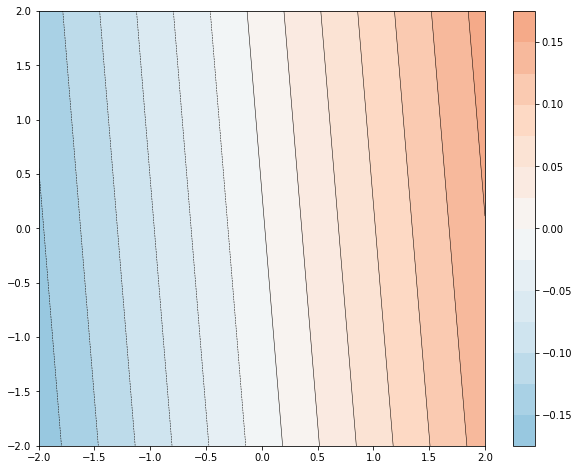

In [70]:
plot_contour(xi, yi, predict(est)) # 모양을 보면 잘 맞지 않음

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp5v4r7t5g/model.ckpt-222
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


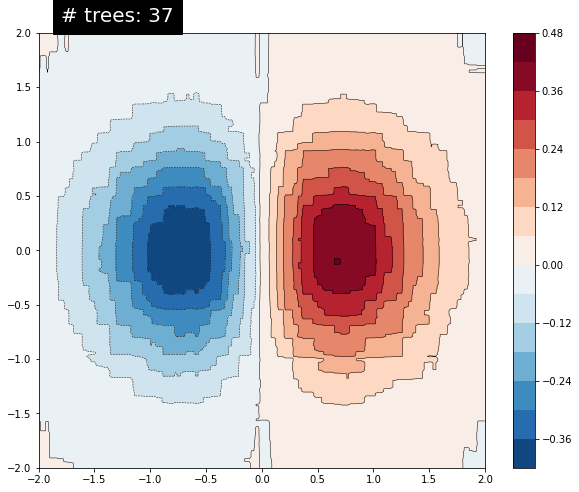

In [71]:
# GBDT 모델(Gradient Boost)에 맞추고 다시 한 번 보기
n_trees = 37 

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0buewtbp/model.ckpt-6
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


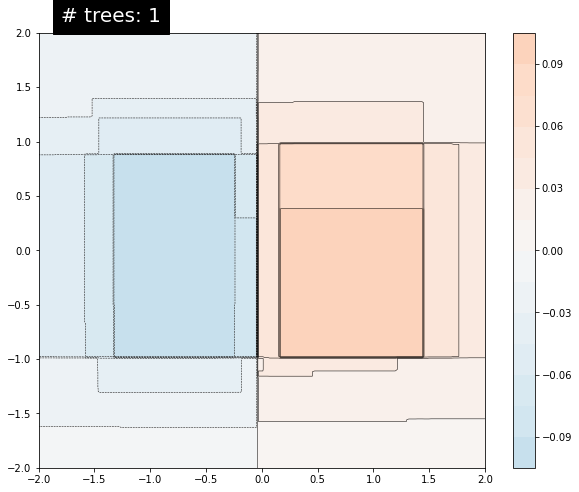

In [74]:
n_trees = 1 # tree의 숫자가 커질수록 모델의 예측이 더욱 일치해짐

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()